### Week 2: Neural network in AWS SageMaker

- Today we are going to use AWS SageMaker to build, train and deploy a VNN. 
- Our data and goal are the same as Week 1 - we will use the Fashion MNIST data and our goal will be to contrust a simple WVV to classify the type of clothing. 

Our Tasks are:
1. Understand the structure of AWS-SageMaker.
2. How to create a instance on AWS-SageMaker.
3. Requesting intances with larger capacity - contact AWS support team 
3. Demonstrate how to build, train, deploy and evaluate a VNN on AWS. 
4. Remeber to **stop instance and DELETE endpoint** when they finish tasks otherwise AWS will keep charging. It can be very expensive.


### Build, train and deploy a NN model in AWS SageMaker
Data
- MNIST fashion data contains 60,000 small square 28 × 28 pixel grayscale images of 10 types of clothing, such as shoes, t-shirts, dresses, and more.
- All the code here is run on kernel **conda_tensorflow_p36** configuration

### A. Sign up for an AWS account 
If you don't already have an account [sign up here](https://portal.aws.amazon.com/billing/signup#/start)

### B. Create an AWS SageMaker instance

We will create a notebook instance that is used to download and process the data. 

1. Sign in to the [AWS SageMaker console](https://aws.amazon.com/console/) as a Root user
![title](pics/sagemaker_console.png)

2. Navigate to Notebook instances in the left menu pane, and select Create notebook instance. 
![title](pics/create_instance.png)

3. Specify your Notebook instance settings
   - Give your new instance a suitable name *e.g.* MA5852-Lab2
   - Select the **instance type** as **ml.t2.medium**. Note: This one is free. If you need intances with different capacity you can select it here. 
   - Leave **elastic inference** as **default selection (none)**
   
4. In the Permissions and encryption section, **create a new IAM role**. Leave the selections as default and select **create role**. Leave the **root access enabled as default**. 
![title](pics/notebook2.png)

5. Choose **Create Notebook instance**.

6. The **Notebook instances** section will now open, and the new notebook instance us displayed. The status will be *pending*, and this status will change to *InService* when the notebook is ready. 
![title](pics/new_instance.png)
  

### C. Preparing the data
We will now use our new notebook instance to load, prepare the Fashion MNIST data and upload the data to Amazon S3. 

1. When your notebook instance status changes to **InService**, select **Open Jupyter**
![title](pics/inservice.png)

Note, you can select Open JupyterLab to get a heap of tutorials etc... 

2. In the Notebook Instance, and either; 
    - create a new notebook using **new** and select the **kernel conda_tensorflow_p36** configuration. A new code cell will appear in your Jupyter notebook. Run the following code by copying and pasting it into your Notebook, or;
    - upload existing jupyter notebooks & python scripts using **upload**. Select the **conda_tensorflow_p36** kernal when prompted.

Before you start: Check directory structure and modify permissions

In [1]:
%%sh
ls -l

total 48
drwx------ 2 ec2-user root     16384 May 13 08:11 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  4268 May 13 08:18 mnist_fashion_vnn_tf2.py
drwxrwxr-x 2 ec2-user ec2-user  4096 May 13 08:18 pics
-rw-rw-r-- 1 ec2-user ec2-user 18269 May 13 08:17 Prac2_SageMaker_VNN_MC_For_Students.ipynb


Do you have a lost+found folder with root group and owner? If so, you will need to change the permissions of to lost+found to prevent future errors. Note, I am in contact with AWS Support for a better solution and will keep you all updated!

In [2]:
%%sh
sudo chown ec2-user lost+found

In [3]:
%%sh
ls -l

total 48
drwx------ 2 ec2-user root     16384 May 13 08:11 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  4268 May 13 08:18 mnist_fashion_vnn_tf2.py
drwxrwxr-x 2 ec2-user ec2-user  4096 May 13 08:18 pics
-rw-rw-r-- 1 ec2-user ec2-user 18269 May 13 08:17 Prac2_SageMaker_VNN_MC_For_Students.ipynb


In [4]:
%%sh
sudo chgrp ec2-user lost+found

In [5]:
%%sh
ls -l 

total 48
drwx------ 2 ec2-user ec2-user 16384 May 13 08:11 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  4268 May 13 08:18 mnist_fashion_vnn_tf2.py
drwxrwxr-x 2 ec2-user ec2-user  4096 May 13 08:18 pics
-rw-rw-r-- 1 ec2-user ec2-user 19160 May 13 08:21 Prac2_SageMaker_VNN_MC_For_Students.ipynb


We next need to set up our environment:

In [6]:
# We first need to import the necessary libraries and define some environment variables  
## Import sagemaker and retrieve IAM role, which determines your user identity and permissions

import sagemaker #import sagemaker
print(sagemaker.__version__) #print the sagemaker version
sess = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.39.1


In [7]:
sess.default_bucket()

'sagemaker-ap-southeast-2-987959606453'

In [8]:
## Import os, keras, numpy, pyplot and the fashion MNIST data 

import os
import keras
import numpy as np
from keras.datasets import fashion_mnist
from matplotlib import pyplot
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

Using TensorFlow backend.



4423680/4422102 [==============================] - 2s 1us/step


x_train_shape & data type: ((60000, 28, 28), dtype('uint8'))
y_train_shape & data type: ((60000,), dtype('uint8'))


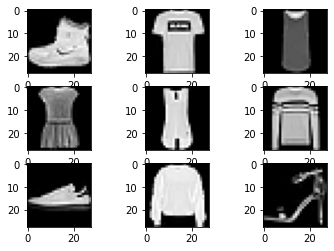

In [9]:
# Take a quick look at data 

#Each image is represented as a 28x28 pixel grayscale images
## View shape and type of data
xtr = x_train.shape, x_train.dtype
ytr = y_train.shape, y_train.dtype

print("x_train_shape & data type:", xtr)
print("y_train_shape & data type:", ytr)

# plot some raw pixel data
for i in range(9):
  
    pyplot.subplot(330 + 1 + i)

    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

In [10]:
# Create local directory for the data and save the test and training data here

os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_val, label=y_val)

In [11]:
%%sh 
ls -l data ## Check that the directories have been created

total 53668
-rw-rw-r-- 1 ec2-user ec2-user  7850506 May 13 08:28 test.npz
-rw-rw-r-- 1 ec2-user ec2-user 47100506 May 13 08:28 training.npz


We are now going to train our model on the local instance - this is an optional step and is to check if our code will run on AWS. We train the model using TensorFlow() to create a tf_estimator object. 

In [12]:
## We will use the python script that made in Lab 1 to train our VNN model. 
## If you haven't already uploaded this into your notebook instance then do that now. 

## We first need to get the python script from Lab 1 for the analysis. Upload into our notebook instance. 

#Import tensorflow from sagemaker
from sagemaker.tensorflow import TensorFlow

## documentation https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html

#Set environment variables - file paths to data and for output
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'
output = 'file:///tmp'

tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn_tf2.py', #path to local python source file to be executed
                          role = role, #the IAM ROLE ARN for the model - unique user ID
                          source_dir ='.', #path to the directory where any other dependancies are apart from entry point
                          instance_count = 1, #the number of EC2 intances to use
                          instance_type ='local', # Type of EC2 instance to use local = this one! 
                          framework_version = '2.1.0', # Tensorflow version for executing your tf code
                          py_version ='py3', #version of python for executing your model training code
                          script_mode =True, #enables us to use our python script to train the model
                          hyperparameters={'epochs':1}, #hyperparameters used by our custom TensorFlow code during model training
                          output_path = output) #location for saving the results. Default = saved in the default S3 bucket.

#Note, Estimator is a high level interface for SageMaker training

In [13]:
#fit is used to train the model saved in the estimator object. We pass in file paths to the 
#trainng and test data (in this example they are stored locally)

tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

Creating jexkh7djlh-algo-1-ba751 ... 
Creating jexkh7djlh-algo-1-ba751 ... done
Attaching to jexkh7djlh-algo-1-ba751
jexkh7djlh-algo-1-ba751 | 2021-05-13 08:31:16,883 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
jexkh7djlh-algo-1-ba751 | 2021-05-13 08:31:16,890 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
jexkh7djlh-algo-1-ba751 | 2021-05-13 08:31:17,966 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
jexkh7djlh-algo-1-ba751 | 2021-05-13 08:31:17,985 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
jexkh7djlh-algo-1-ba751 | 2021-05-13 08:31:18,003 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
jexkh7djlh-algo-1-ba751 | 2021-05-13 08:31:18,016 sagemaker-containers INFO     Invoking user script
jexkh7djlh-algo-1-ba751 | 
jexkh7djlh-algo-1-ba751 | Training Env:
jexkh7djlh-algo-1-ba751 | 
jexkh7djlh-algo-1-ba751 | {
jexkh7djlh-al

jexkh7djlh-algo-1-ba751 | Using TensorFlow backend.
jexkh7djlh-algo-1-ba751 | Collecting keras-metrics
jexkh7djlh-algo-1-ba751 |   Downloading keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)
jexkh7djlh-algo-1-ba751 | Requirement already satisfied: Keras>=2.1.5 in /usr/local/lib/python3.6/dist-packages (from keras-metrics) (2.3.1)
jexkh7djlh-algo-1-ba751 | Requirement already satisfied: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.14.0)
jexkh7djlh-algo-1-ba751 | Requirement already satisfied: pyyaml in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (5.3.1)
jexkh7djlh-algo-1-ba751 | Requirement already satisfied: h5py in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (2.10.0)
jexkh7djlh-algo-1-ba751 | Requirement already satisfied: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.4.1)
jexkh7djlh-algo-1-ba751 | Requirement already satisfied: kera

### Train the model in AWS

Now we know that our code is working on SageMaker (note, we can only do this because we have a small dataset and a shallow neural network - this wouldn't work with large datasets or deep neural networks), we can train our model on a larger instance. 

1. Upload the dataset to S3. S3 is a default bucket for storing data and model output in AWS
2. Select the [EC2 instance type](https://aws.amazon.com/ec2/instance-types/?trkCampaign=acq_paid_search_brand&sc_channel=PS&sc_campaign=acquisition_ANZ&sc_publisher=Google&sc_category=Cloud%20Computing&sc_country=ANZ&sc_geo=APAC&sc_outcome=acq&sc_detail=aws%20ec2%20instance%20pricing&sc_content={ad%20group}&sc_matchtype=e&sc_segment=489278081276&sc_medium=ACQ-P|PS-GO|Brand|Desktop|SU|Cloud%20Computing|EC2|ANZ|EN|Sitelink&s_kwcid=AL!4422!3!489278081276!e!!g!!aws%20ec2%20instance%20pricing&ef_id=Cj0KCQjw1PSDBhDbARIsAPeTqrdxZQ3nAtQNtB_MzOowvGLxppgm3YnqP08nDUrv8ubtE_Y19XwRNIcaAkaXEALw_wcB:G:s&s_kwcid=AL!4422!3!489278081276!e!!g!!aws%20ec2%20instance%20pricing) for your model. For this subject, we mainly use *ml.m4.xlarge*. EC stands for Elastic Compute Clous, and its a web service where AWS subscribers can request and provision compute services in the AWS cloud. You'll be charged per hour with different rates, depending on the instance you choose. Don't forget to terminate the instance when you're done to stop being over-charged. 

In [14]:
#Upload data to S3 bucket
## Note - we get a certain capacity for free, after that you are charged

prefix = 'keras-mnist-fashion' #first define a prefix for the key (think of this like a directory or file path)

#upload a local file/directory to S3 using upload_data(). 
##inputs = path, bucket (if not specifified will use default_bucket), optional prefix for directory structure
training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

print(training_input_path)
print(test_input_path) ### note - you can look at your buckets in the S3 section of AWS. 

s3://sagemaker-ap-southeast-2-987959606453/keras-mnist-fashion/training/training.npz
s3://sagemaker-ap-southeast-2-987959606453/keras-mnist-fashion/validation/test.npz


### Train with managed instances

Used [managed spot instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-spot-instances.html) to save money. 

In [15]:
tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn_tf2.py',  #Python script
                          source_dir = '.',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge', # instance type
                          framework_version='2.1.0', # Tensorflow version
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 3},
                          ## after this line, everything is optional for managed spot instance
                          use_spot_instances=True,        # Use spot instance
                          max_run=3600,                    # Max training time
                          max_wait=7200,                  # Max training time + spot waiting time
                         ) ##note for martha ## means optional - money saving. only downside, if under-specify then will kill job. 


In [16]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

2021-05-13 08:46:39 Starting - Starting the training job...ProfilerReport-1620895574: InProgress
...
2021-05-13 08:47:24 Starting - Launching requested ML instances.........
2021-05-13 08:49:00 Starting - Preparing the instances for training.........
2021-05-13 08:50:40 Downloading - Downloading input data
2021-05-13 08:50:40 Training - Downloading the training image...
2021-05-13 08:51:00 Training - Training image download completed. Training in progress.2021-05-13 08:51:02,056 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-13 08:51:02,064 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-13 08:51:03,436 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-13 08:51:03,458 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-13 08:51:03,478 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-13 08:51:03,492

Validation loss    : 0.42637978751659394
Validation accuracy: 0.8495
2021-05-13 08:51:18.460754: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /opt/ml/model/1/assets
INFO:tensorflow:Assets written to: /opt/ml/model/1/assets
[2021-05-13 08:51:18.909 ip-10-0-162-104.ap-southeast-2.compute.internal:28 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2021-05-13 08:51:19,431 sagemaker-containers INFO     Reporting training SUCCESS

2021-05-13 08:51:41 Uploading - Uploading generated training model
2021-05-13 08:51:41 Completed - Training job completed
Training seconds: 65
Billable seconds: 18
Managed Spot Training savings: 72.3%


### Deploy the model

- Model deployment means to expose the model to real use.
- This means you can make inferences or predictions using your model, 
- The model is deployed in an EC2 instance 
- Deployment is via Amazon SageMaker endpoints – an Amazon SageMaker endpoint is a fully managed service that allows you to make real-time inferences via a REST API. 



In [17]:
import time

tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()) #give the endpoint a name.
#used the time and date from the time library

#deploy() Deploys the Model to an Endpoint and optionally return a Predictor.
tf_predictor = tf_estimator.deploy(initial_instance_count=1, # The initial number of instances to run in the Endpoint created from this Model.
                                   instance_type='ml.m4.xlarge', # The EC2 instance type to deploy this Model to.
                                   endpoint_name=tf_endpoint_name) # The name of the endpoint to create     

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

### Prediction exercise


[[9.09648370e-03 2.31886120e-03 3.85227939e-03 6.13034889e-03
  6.18623570e-04 8.95465791e-01 4.74554813e-03 5.64219318e-02
  8.18474591e-03 1.31653426e-02]
 [1.49433297e-04 2.62322756e-05 1.21041021e-05 8.75733895e-06
  1.76503000e-06 4.97946236e-03 8.86180000e-05 9.53699172e-01
  4.01310157e-04 4.06331047e-02]
 [3.74274552e-02 5.36061311e-03 7.80310392e-01 1.00848908e-02
  5.45848757e-02 8.97777849e-04 8.63694000e-02 2.89916370e-05
  2.48042066e-02 1.31371504e-04]
 [2.36719614e-03 5.92323879e-08 3.87049193e-04 8.08104517e-07
  1.81694000e-03 4.92941794e-08 3.42829735e-03 1.64965385e-07
  9.91999090e-01 1.60364252e-07]
 [6.82571681e-07 1.84371665e-08 4.59264049e-09 1.57821827e-08
  4.64155714e-10 2.62800464e-03 3.75045808e-08 6.75755925e-03
  5.16541058e-06 9.90608573e-01]
 [7.72682085e-07 4.91595742e-08 5.74235859e-09 7.06382863e-09
  2.44791604e-10 1.12660811e-03 4.72965027e-08 1.07196786e-01
  2.06817299e-06 8.91673684e-01]
 [3.25126084e-03 3.70586501e-03 2.07151985e-03 9.85282421e

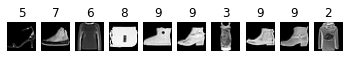

In [18]:
  %matplotlib inline
import random #random number generator for random sampling
import matplotlib.pyplot as plt #for plotting

#select 10 of the test samples (images) randomly
num_samples = 10
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples): #plot them with their labels 
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
# Generate predictions for those random test images
# Apply the preductor() function to a Predictor oject
# It returns inferences for the given input - in this case the images

prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction) #save the predictions as a np.array (softmax decimal probabilties)
print(prediction)
predicted_labels = prediction.argmax(axis=1) #use argmax to turn the predictions into class labels
print('Predicted labels are: {}'.format(predicted_labels)) # print out the labels

### Delete the endpoint

Remember to delete the endpoint when you are not using to avoid unnecessary surcharge from AWS.

In [19]:
tf_predictor.delete_endpoint()